<a href="https://colab.research.google.com/github/tngzng/slack-audit/blob/main/slack_message_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Slack Message Analysis

This notebook combines message data collected with the accompanying Slack [audit scraper](https://github.com/tngzng/slack-audit) and your own custom diversity data. It provides helper functions to quickly visualize breakdowns of Slack messages by gender, race, or any other column present in your diversity data. 

**A note on usage:**

👤 indicates sections where input is needed from you.

🤖 indicates cells you can run without modification. 

## install requirements 🤖

In [ ]:
import io
import datetime
from typing import List

from google.colab import files
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")
sns.set_palette("colorblind")

## upload files 👤

Upload the collected Slack messages, along with your own spreadsheet of diversity stats.

In [ ]:
diversity_upload = files.upload()

Saving diversity-data.csv to diversity-data (1).csv


In [ ]:
slack_upload = files.upload()


Saving lnl-daily-standup.csv to lnl-daily-standup (1).csv


## set constants 👤

Set the file names and column names specific to your upload.

In [ ]:
# set the name of the diversity data file you uploaded.
DIVERSITY_FILE = 'diversity-data.csv'

# set the name of the slack message data file you uploaded.
SLACK_FILE = 'lnl-daily-standup.csv'

# set the name of the email column in your diversity data. this is used to join the diversity and message data.
DIVERSITY_EMAIL = 'Email'

# set any additional column names in your diversity data that you would like to reference later.
GENDER_DIVERSE = 'Woman or gender-nonconforming' 
POC = 'POC'

## prepare data 🤖

Prepare data so we can easily visualize it. 

In [ ]:
diversity_df = pd.read_csv(io.BytesIO(diversity_upload[DIVERSITY_FILE]))
df = pd.read_csv(io.BytesIO(slack_upload[SLACK_FILE]))

In [ ]:
EMAIL = 'user_email' 
TS = 'message_ts'
DATE = 'message_date_exact'
AGG_DATE = 'message_date'
COUNT = 'count'

def validate_df(message_df: pd.DataFrame, diversity_df: pd.DataFrame) -> pd.DataFrame:
  message_users = message_df[EMAIL].unique()
  all_users = diversity_df[DIVERSITY_EMAIL]
  try:
    assert set(message_users).issubset(set(all_users))
  except AssertionError: 
    print('Validation error: the diversity data provided does not contain all the users in the slack data')


def prepare_df(message_df: pd.DataFrame, diversity_df: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame):
  message_df = pd.merge(message_df, diversity_df, left_on=EMAIL, right_on=DIVERSITY_EMAIL)
  message_df[DATE] = message_df[TS].apply(lambda ts: datetime.datetime.utcfromtimestamp(ts))
  message_df[AGG_DATE] = message_df[DATE].apply(lambda dt: f'{dt.year}-{dt.month}') 
  channel_user_df = diversity_df[diversity_df[DIVERSITY_EMAIL].isin(message_df[EMAIL].unique())]
  return message_df, channel_user_df

validate_df(df, diversity_df)
df, channel_user_df = prepare_df(df, diversity_df)


## set column for total comparison 👤

Specify the column you would like to visualize in a barplot. 




In [ ]:
# the example below uses racial diversity data, but you can use any column available in your diversity stats.
BARPLOT_COL = POC

## plot totals 🤖

See how the total number of messages varies by the column you specified above.

In [ ]:
def barplot(df: pd.DataFrame, col: str, title: str) -> None:
  ax = sns.countplot(x=col, data=df).set_title(title)

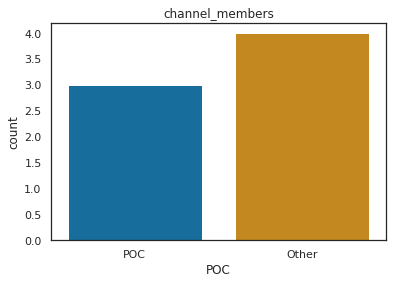

In [ ]:
barplot(channel_user_df, BARPLOT_COL, 'channel_members')

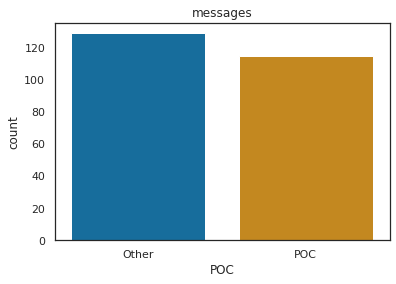

In [ ]:
barplot(df, BARPLOT_COL, 'messages')

## set column for comparison over time 👤

Specify the column you would like to visualize in a timeseries barplot. 



In [ ]:
# specify the column to rollup here.
# the example shows gender diversity data, but you can use any column available in your diversity stats.
TIMESERIES_COL = GENDER_DIVERSE

## plot comparison over time 🤖

Rollup messages by date and see how trends for a column change over time.

In [ ]:
def date_rollup(df: pd.DataFrame, col: str) -> pd.DataFrame:
  aggregated_df = df[[AGG_DATE, col]]
  aggregated_df[COUNT] = 1
  return aggregated_df.groupby([AGG_DATE, col], as_index=False).sum()

time_series_df = date_rollup(df, TIMESERIES_COL)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


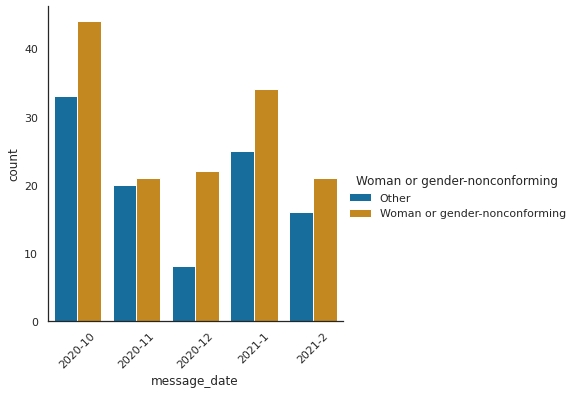

In [ ]:
def timeseries_barplot(df: pd.DataFrame, col: str) -> None:
  g = sns.catplot(x=AGG_DATE, y=COUNT, hue=col, kind="bar", data=df)
  g.set_xticklabels(rotation=45)


timeseries_barplot(time_series_df, TIMESERIES_COL)